Installing and Importing Libraries

In [1]:
#Installing PyBullet, OpenCV-Python & Matplotlib:

!pip install pybullet opencv-python matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873467 sha256=db3c0521a797b6b3e51ab2bfe60d020ce7abc2574f332f0d5b8616420dc96e95
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet


In [2]:
# Importing Libraries suitable for File handling:

import os

# Importing Libraries suitable for Numerical & Scientific Computing:

import numpy as np

# Importing Libraries for Robotics Simulation (Physics & URDF handling):

import pybullet as p
import pybullet_data

# Importing Libraries suitable for Data Visualization:

import matplotlib.pyplot as plt

Importing the URDF files from GitHub

In [3]:
!git clone https://github.com/LEOGLAUDIAS/MSc-RSP-RS-PyBullet.git

Cloning into 'MSc-RSP-RS-PyBullet'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 6.12 KiB | 3.06 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
!ls /content/MSc-RSP-RS-PyBullet/urdf_files

box.urdf  pillar.urdf  table.urdf  two_wheeler_robot.urdf  wall.urdf


In [5]:
URDF_FOLDER = "/content/MSc-RSP-RS-PyBullet/urdf_files"

Helper Functions

In [6]:
# Helper function to save URDF text (if needed):

def save_urdf(filename, content):
    path = os.path.join(URDF_FOLDER, filename)
    with open(path, "w") as f:
        f.write(content)
    print("Saved:", path)

In [7]:
# Simulation setup:

def setup_sim():
    p.connect(p.DIRECT)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.resetSimulation()
    p.setGravity(0, 0, -9.81)
    plane = p.loadURDF("plane.urdf")
    return plane

# Load the scene (robot + objects):

def load_scene():
    bodies = {}
    bodies["robot"] = p.loadURDF(os.path.join(URDF_FOLDER, "two_wheeler_robot.urdf"), [0,0,0.1])
    bodies["wall"] = p.loadURDF(os.path.join(URDF_FOLDER, "wall.urdf"), [2,0,0.5], useFixedBase=True)
    bodies["pillar"] = p.loadURDF(os.path.join(URDF_FOLDER, "pillar.urdf"), [-1,1,0.5], useFixedBase=True)
    bodies["table"] = p.loadURDF(os.path.join(URDF_FOLDER, "table.urdf"), [0,2,0.375], useFixedBase=True)
    bodies["box1"] = p.loadURDF(os.path.join(URDF_FOLDER, "box.urdf"), [-2,-1,0.25], useFixedBase=True)
    bodies["box2"] = p.loadURDF(os.path.join(URDF_FOLDER, "box.urdf"), [1,-1.5,0.25], useFixedBase=True)
    return bodies

# Reset robot pose:

def set_robot_pose(robot_id, pos):
    orn = p.getQuaternionFromEuler([0,0,0])
    p.resetBasePositionAndOrientation(robot_id, pos, orn)

# Camera image capture:

def capture_image(target=[0,0,0], distance=5, yaw=45, pitch=-30):
    view = p.computeViewMatrixFromYawPitchRoll(target, distance, yaw, pitch, 0, 2)
    proj = p.computeProjectionMatrixFOV(60, 1.0, 0.1, 100)
    w,h,rgba,_,_ = p.getCameraImage(640,480,view,proj)
    return np.reshape(rgba,(h,w,4))

Defining Experiment Parameters

In [8]:
# Initialize the simulation and load the scene to get the robot ID:
# Initialize:

setup_sim()
bodies = load_scene()
robot_id = bodies['robot']

# Defining robot positions (3):

robot_positions = [
    [0, 0, 0.1],    # center
    [1, 1, 0.1],    # forward-right
    [-1, -1, 0.1]   # back-left
]

# Defining camera setups (3):

camera_setups = [
    dict(cameraTargetPosition=[0,0,0], distance=5, yaw=45, pitch=-30),
    dict(cameraTargetPosition=[0,0,0], distance=5, yaw=-45, pitch=-20),
    dict(cameraTargetPosition=[0,0,0], distance=6, yaw=90, pitch=-25)
]

In [9]:
# Helper function to capture images:

def capture_image(cameraTargetPosition, distance, yaw, pitch, roll=0.0, fov=60, width=640, height=480):
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=cameraTargetPosition,
        distance=distance, yaw=yaw, pitch=pitch, roll=roll, upAxisIndex=2
    )
    proj = p.computeProjectionMatrixFOV(fov=fov, aspect=width/height, nearVal=0.1, farVal=100)
    w, h, rgba, depth, seg = p.getCameraImage(width=width, height=height, viewMatrix=view, projectionMatrix=proj)
    return np.reshape(rgba, (h, w, 4))

Run Simulation + Capture Images

In [10]:
# Capture images:

all_images = []
for pos in robot_positions:

    # Move robot:

    p.resetBasePositionAndOrientation(robot_id, pos, [0,0,0,1])
    imgs_for_this_pose = []
    for cam in camera_setups:
        img = capture_image(**cam)
        imgs_for_this_pose.append(img)
    all_images.append(imgs_for_this_pose)

Visualization

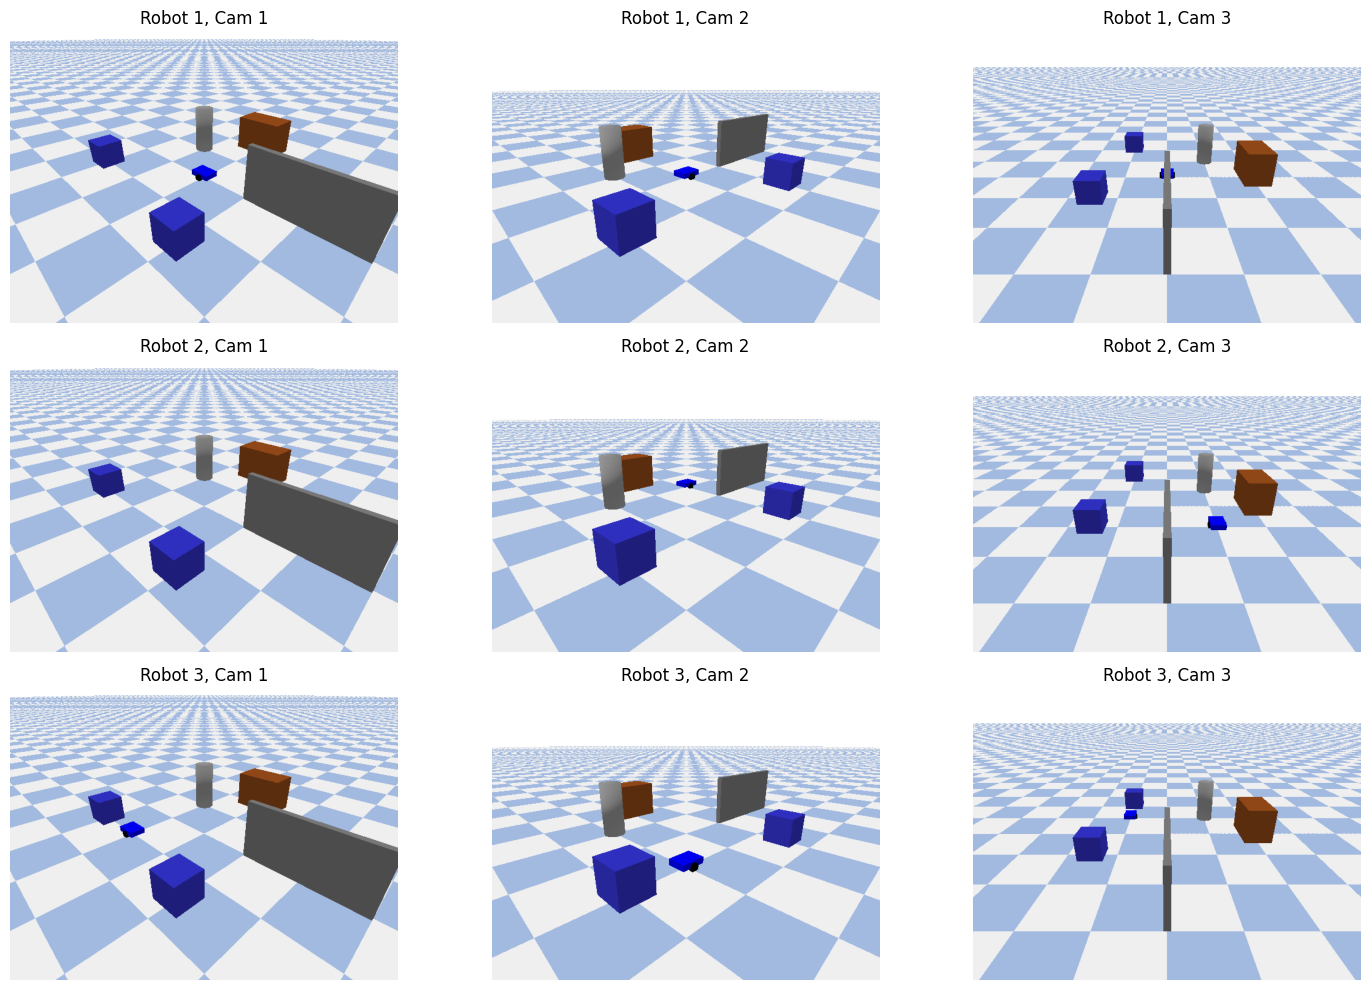

In [11]:
# Displaying results in a 3x3 grid:

fig, axes = plt.subplots(len(robot_positions), len(camera_setups), figsize=(15,10))
for i in range(len(robot_positions)):
    for j in range(len(camera_setups)):
        axes[i,j].imshow(all_images[i][j])
        axes[i,j].axis("off")
        axes[i,j].set_title(f"Robot {i+1}, Cam {j+1}")
plt.tight_layout()
plt.show()